# Assignment Part 1 - Data Scraping and Transformation

### The assignment includes scraping unstructured data available openly on Wikipedia and transform it into Structured format with cleaning up to be used for Analysis

#### Define and import pre-requisites for Python - Pandas and Data Scraping using BeautifulSoup

In [1]:
from bs4 import BeautifulSoup # Beautiful Soup Data scraping library
import numpy as np # data in a vectorized manner manipulation
import pandas as pd # Pandas data analsysis library
import requests # HTTP library
from sklearn.cluster import KMeans # Data clustering algorithm


!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('All Libraries are imported.')


Solving environment: done

# All requested packages already installed.

All Libraries are imported.


### Scraping Data from Open Website - Wikipedia.

#### scrape the following Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M, in order to obtain the data that is in the table of postal codes

In [2]:
List_url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
source = requests.get(List_url).text

In [3]:
soup = BeautifulSoup(source, 'xml')
table=soup.find('table')

In [4]:
column_names = ['Postalcode','Borough','Neighborhood']
df = pd.DataFrame(columns = column_names)
for tr_cell in table.find_all('tr'):
    row_data=[]
    for td_cell in tr_cell.find_all('td'):
        row_data.append(td_cell.text.strip())
    if len(row_data)==3:
        df.loc[len(df)] = row_data

#### List first 4 rows from imported data

In [5]:
df.head(4)

,Postalcode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village


### Data Cleaning to remove Blank or unassigned Borough

#### The "Not assigned" values will be replaced with the Borough name in that cell from the Neighborhood column

In [6]:
df=df[df['Borough']!='Not assigned']

df[df['Neighborhood']=='Not assigned']=df['Borough']
df.head(4)
      

,Postalcode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights


In [7]:
temp_df=df.groupby('Postalcode')['Neighborhood'].apply(lambda x: "%s" % ', '.join(x))
temp_df=temp_df.reset_index(drop=False)
temp_df.rename(columns={'Neighborhood':'Neighborhood_joined'},inplace=True)

df_merge = pd.merge(df, temp_df, on='Postalcode')

df_merge.drop(['Neighborhood'],axis=1,inplace=True)

df_merge.drop_duplicates(inplace=True)

df_merge.rename(columns={'Neighborhood_joined':'Neighborhood'},inplace=True)

df_merge.head()

,Postalcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
5,Queen's Park,Queen's Park,Queen's Park


#### Print the number of rows of dataframe using ".shape" option

In [8]:
print('The DataFrame shape is', df_merge.shape)

The DataFrame shape is (103, 3)


# Assignment Part 2 - Connecting geographical co-ordinates to Postal codes

#### Read a csv file with Geo co-ordinates and verify the contents. This is an alternative provided than use of Geocode Package.

In [9]:
geo_df=pd.read_csv('http://cocl.us/Geospatial_data')

In [10]:
geo_df.head(4)

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917


#### Rename the Column from above dataset to "PostalCode" as requested in the assignment.

In [11]:
geo_df.rename(columns={'Postal Code':'PostalCode'},inplace=True)

In [12]:
geo_df.head(4)

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917


#### Merge two tables using column "PostalCode" as the common thread. Display and verify the merged contents

In [13]:
df_merge.rename(columns={'Postalcode':'PostalCode'},inplace=True)

In [14]:
postcodes_Geo_coordinates_df = df_merge.join(geo_df.set_index('PostalCode'), on='PostalCode')

In [15]:
postcodes_Geo_coordinates_df.head(4)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763


# Assignment Part 3 - Explore and Cluster neighborhoods. Generate Maps.

### Explore and Cluster the neighborhoods in Toronto. Analyse and Report Observations. Visualise to find how the neighborhoods cluster together. Use of Four Square to Get Venues.

### Filter the data for Neighborhood around Toronto Borough

In [16]:
toronto_neb=postcodes_Geo_coordinates_df[postcodes_Geo_coordinates_df['Borough'].str.contains("Toronto")]
toronto_neb.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
12,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937
26,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
35,M4E,East Toronto,The Beaches,43.676357,-79.293031
36,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306


### Define Four Square Credentials for connection

In [17]:
CLIENT_ID = 'RBXPFBH4ZFHE2M5ANPHVYSQJPNODSYV0GWMYP3OMKPN3I1R2'
CLIENT_SECRET = 'OC2Q1YVHIOWIKHEXYBY5TTAE4PCT4GFHBKCPDKLSQUG2RZXN'
VERSION = '20180604'
LIMIT = 30
print('Your credentails passed with Four Square Version : ' +  VERSION )

Your credentails passed with Four Square Version : 20180604


In [18]:
def getNearbyVenues(names, latitudes, longitudes):
    radius=500
    LIMIT=100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
        
 # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(name,lat,lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 'Neighborhood Latitude','Neighborhood Longitude', 'Venues', 'Venues Latitude','Venues Longitude', 'Venues Category']
    
    return(nearby_venues)

In [19]:
trt_venues = getNearbyVenues(names=toronto_neb['Neighborhood'], latitudes=toronto_neb['Latitude'], longitudes=toronto_neb['Longitude'])
trt_venues.head(4)

Harbourfront
Ryerson, Garden District
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Adelaide, King, Richmond
Dovercourt Village, Dufferin
Harbourfront East, Toronto Islands, Union Station
Little Portugal, Trinity
The Danforth West, Riverdale
Design Exchange, Toronto Dominion Centre
Brockton, Exhibition Place, Parkdale Village
The Beaches West, India Bazaar
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North, Forest Hill West
High Park, The Junction South
North Toronto West
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
Harbord, University of Toronto
Runnymede, Swansea
Moore Park, Summerhill East
Chinatown, Grange Park, Kensington Market
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Rosedale
Stn A PO Boxes 25 The Esplanade
Cabbagetown, St. James Town
First Canadian P

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venues,Venues Latitude,Venues Longitude,Venues Category
0,Harbourfront,43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,Harbourfront,43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,Harbourfront,43.65426,-79.360636,Cooper Koo Family YMCA,43.653191,-79.357947,Gym / Fitness Center
3,Harbourfront,43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa


In [20]:
trt_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venues,Venues Latitude,Venues Longitude,Venues Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Berczy Park,58,58,58,58,58,58
"Brockton, Exhibition Place, Parkdale Village",21,21,21,21,21,21
Business Reply Mail Processing Centre 969 Eastern,17,17,17,17,17,17
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",16,16,16,16,16,16
"Cabbagetown, St. James Town",47,47,47,47,47,47
Central Bay Street,80,80,80,80,80,80
"Chinatown, Grange Park, Kensington Market",92,92,92,92,92,92
Christie,17,17,17,17,17,17


In [21]:
# one hot encoding
tor_onehot = pd.get_dummies(trt_venues[['Venues']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
tor_onehot['Neighborhood'] = trt_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [tor_onehot.columns[-1]] + list(tor_onehot.columns[:-1])
tor_onehot = tor_onehot[fixed_columns]

tor_grouped = tor_onehot.groupby('Neighborhood').mean().reset_index()

In [22]:
print('The total number of venues returned is ', tor_onehot.shape[0])
tor_grouped.head(4)

The total number of venues returned is  1690


,Neighborhood,306 Yonge Street - Jordan Store,360 Restaurant,4 Life Natural Foods,401 Games,7 Numbers,7 West Cafe,7-Eleven,A & C Games,A & C World,...,freshii,i deal coffee,iQ Food Co,iQ Food Co. (First Canadian Place),lululemon,lululemon athletica,nodo,souvlaki express,½ oz. Cocktail Emporium,金城超級市場 Lucky Moose Food Mart
0,"Adelaide, King, Richmond",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0
1,Berczy Park,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
2,"Brockton, Exhibition Place, Parkdale Village",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
3,Business Reply Mail Processing Centre 969 Eastern,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
print('Total Toronto Neighbourhoods:', tor_grouped['Neighborhood'].shape[0])

Total Toronto Neighbourhoods: 38


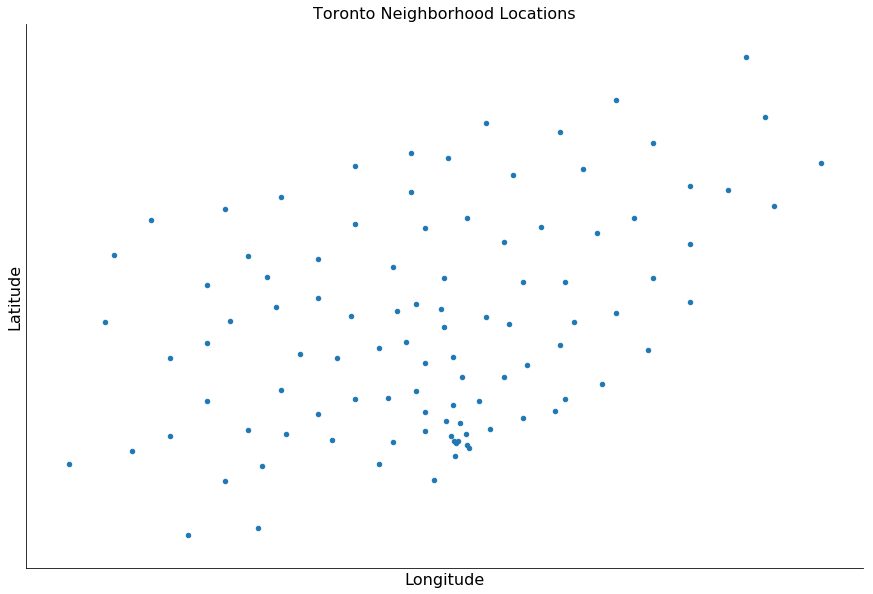

In [30]:
import matplotlib.pyplot as plt

X = postcodes_Geo_coordinates_df[['Longitude', 'Latitude']]

scatter_plot = X.plot.scatter(x='Longitude', 
               y='Latitude',  
               fontsize = 16,
               figsize=(15, 10))

scatter_plot.set_yticklabels([])
scatter_plot.set_xticklabels([])
scatter_plot.set_xticks([])
scatter_plot.set_yticks([])
scatter_plot.spines['top'].set_color(None)
scatter_plot.spines['right'].set_color(None)
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
scatter_plot.set_title('Toronto Neighborhood Locations', fontsize=16)

scatter_plot.set_yticklabels(labels = 'Latitude', fontdict={'fontsize': 20})
plt.show()

In [31]:
# set number of clusters
k = 4

tor_grouped_clustering = tor_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=k, random_state=0).fit(tor_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:38]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [38]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [39]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = tor_grouped['Neighborhood']

for ind in np.arange(tor_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(tor_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Starbucks,JaBistro,Michael's on Simcoe,Bell Trinity Square,Byblos Toronto,Bymark,Daily Press Juicery,Planta Queen,Four Seasons Centre for the Performing Arts,The National Club
1,Berczy Park,Starbucks,Crepe It Up!,St. Urbain Bagel,Brookfield Place,Chroma,Chotto Matte,Stonemill Bread,Meridian Hall,St. Lawrence Market (South Building),Market Street Catch
2,"Brockton, Exhibition Place, Parkdale Village",Structube,Caffino,Joe Rockhead's Climbing Gym,Uma Cafe,The Abbott,Reebok Crossfit Liberty Village,Vogue Supper Club,Mike's Liberty Grill,Quiznos,Queen Supermarket
3,Business Reply Mail Processing Centre 969 Eastern,Queen Margherita Pizza,TTC Russell Division,Chino Locos,Greenwood Cigar & Variety,Jonathan Ashbridge Park,Amin Car Repair Garage,Ashbridges Bay Skatepark,The Ten Spot,Rorschach Brewing Co.,The Green Wood
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Crew Room,Air Canada Check-In Counter,Want Passport,ORNGE - Toronto Air Base,Billy Bishop Toronto City Airport (YTZ) (Billy...,Hanlan's Point Ferry,Billy Bishop Café,Porter Lounge,Porter Airlines Check-In Counter,Market@416


#### Using the Segmenting and Clustering the analysis can help in Real Estate decision making, Banking and Finance solution / offers rollout along with insurances, Security systems implementation, Planning Emergency and Rescue systems.